In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import expit  # Sigmoid function for logistic link

from typing import Any, Optional

import torch
from torch import Tensor
from torch.distributions import Laplace

from gpytorch.constraints import Interval, Positive
from gpytorch.distributions import base_distributions
from gpytorch.priors import Prior
from gpytorch.likelihoods.likelihood import _OneDimensionalLikelihood

from typing import Any, Optional

import torch
from torch import Tensor
from torch.distributions import Laplace

from gpytorch.constraints import Interval, Positive
from gpytorch.distributions import base_distributions
from gpytorch.priors import Prior
from gpytorch.likelihoods.likelihood import _OneDimensionalLikelihood


import urllib.request
import os
from scipy.io import loadmat
from math import floor
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution, DeltaVariationalDistribution, MeanFieldVariationalDistribution
from gpytorch.variational import VariationalStrategy
from sklearn.preprocessing import MinMaxScaler, StandardScaler


N = 1000
r = 1
pi=0.35
X = torch.normal(mean=0, std =1, size=(1,N)).double().cuda().flatten()
mu = torch.exp(X)
probs = r / (mu + r)
y = base_distributions.ZeroInflatedNegativeBinomial(
    total_count = r, probs=probs, gate=torch.tensor([pi]).double().cuda()
).sample().double().cuda().flatten()

In [2]:
from typing import Any, Optional

import torch
from torch import Tensor
from torch.distributions import Laplace

from gpytorch.constraints import Interval, Positive
from gpytorch.distributions import base_distributions
from gpytorch.priors import Prior
from gpytorch.likelihoods.likelihood import _OneDimensionalLikelihood

class ZeroInflatedNegativeBinomialLikelihood(_OneDimensionalLikelihood):
    def __init__(
        self,
        batch_shape: torch.Size = torch.Size([])
    ) -> None:
        super().__init__()        
        
    def forward(self, function_samples: Tensor, *args: Any, **kwargs: Any) -> base_distributions.ZeroInflatedNegativeBinomial:
        gate_logits = function_samples[..., 0]
        total_count_log = function_samples[..., 1]
        probs_logits = function_samples[..., 2]

        r = torch.exp(total_count_log)
        n = torch.sigmoid(probs_logits)
        pi = torch.sigmoid(gate_logits)

        return base_distributions.ZeroInflatedNegativeBinomial(total_count = r, probs=n, gate=pi)

In [3]:
class GPModel(ApproximateGP):
    def __init__(self, inducing_points, num_tasks):
        variational_distribution = gpytorch.variational.NaturalVariationalDistribution(inducing_points.size(0), batch_shape=torch.Size([num_tasks]))
        variational_strategy = gpytorch.variational.IndependentMultitaskVariationalStrategy(
            gpytorch.variational.VariationalStrategy(
                self, inducing_points, variational_distribution, learn_inducing_locations=True
            ), 
            num_tasks=num_tasks
        )
        

        super(GPModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([num_tasks]))
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.LinearKernel(batch_shape=torch.Size([num_tasks])),
            batch_shape=torch.Size([num_tasks])
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

inducing_points = X.clone()
M = 100
inducing_points = torch.normal(mean=0, std =1, size=(1,N)).double().cuda().flatten()
model = GPModel(inducing_points=inducing_points, num_tasks=3).double()
likelihood = ZeroInflatedNegativeBinomialLikelihood().double()

if torch.cuda.is_available():
    model = model.cuda()
    likelihood = likelihood.cuda()

model.train()
likelihood.train()
likelihood.initialize()

variational_ngd_optimizer = gpytorch.optim.NGD(model.variational_parameters(), num_data=y.size(0), lr=0.1)

hyperparameter_optimizer = torch.optim.Adam([
    {'params': model.hyperparameters()},
    {'params': likelihood.parameters()},
], lr=0.01)

mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=y.size(0))

n_epochs = 500
for i in range(1, n_epochs + 1):
    if i % (n_epochs // 10) == 0:
        print(i)
        print(loss.item())
    variational_ngd_optimizer.zero_grad()
    hyperparameter_optimizer.zero_grad()
    output = model(X)
    loss = -mll(output, y)
    loss.backward()
    variational_ngd_optimizer.step()
    hyperparameter_optimizer.step()

50
1.1518954381578825
100
1.1496353102893404
150
1.1488953317649913
200
1.1487279331499645
250
1.1486820693474034
300
1.1486571388788025
350
1.1486358772188006
400
1.1486158004266862
450
1.1485966260710303
500
1.1485783361754751


<Axes: xlabel='X1', ylabel='y'>

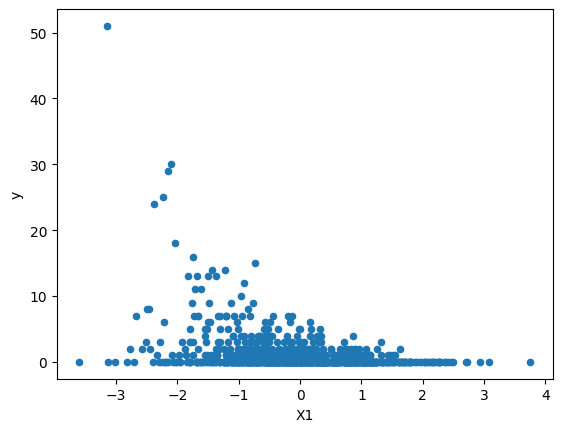

In [10]:
model.eval()
likelihood.eval()
with torch.no_grad():
    preds = likelihood(model(X))

results_df = pd.DataFrame(dict(
    y=y.cpu().numpy(),
    X1=X.cpu().numpy(),
    preds=preds.sample().median(axis=0).values.cpu().numpy()
))

results_df.plot.scatter("X1", "y")

<Axes: xlabel='X1', ylabel='preds'>

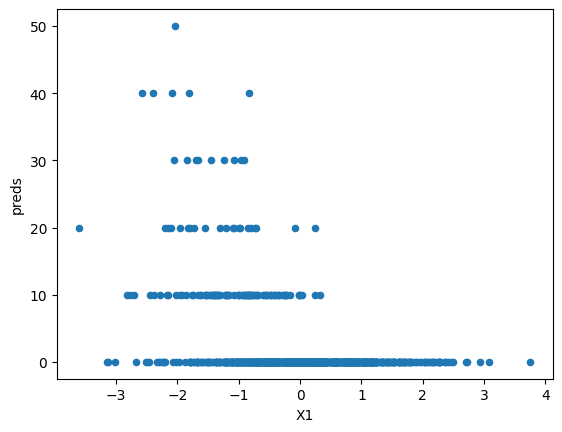

In [11]:
results_df.plot.scatter("X1", "preds")